# Artificial Neural Networks (CS-456)
## Miniproject 1: Tic Tac Toe
- Mickaël Achkar (322190)
- Yehya El Hassan (325932)


In [1]:
import numpy as np
from tic_env import TictactoeEnv, OptimalPlayer
from typing import Dict, List, Union, Callable
import hashlib
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
from scipy.stats import binned_statistic
from random import randrange
import seaborn as sns

In order to implement an agent that utilizes reinforecement learning to play Tic Tac Toe, we implemented an RLAgent class. This class handles all the needed functionalities of the RL agent such as:

* `observe_state` which stores the game board and updates the list of possible actions.
* `get_epsilon` which returns the value of epsilon. Epsilon can be either fixed or monotonically decreasing as discussed later.
* `update_nb_of_episode_played` which updates the number of episodes played to calculate the value of the monotonically decreasing epsilon.
* `observe_reward` which updates the internal stored value of the reward given by the environment.
* `act` which selects an action from a list of possibled actions based on $\epsilon$-greedy strategy.
* `update_q_table` which stores and updates a table that contains a $Q$-value for every state and action possible in the given environment.

In addition, other internal functions are denoted by a `_` prefix to implement the above discussed functionalities.

In [2]:
class RlAgent():
    def __init__(self, player: str, epsilon: Union[float, Callable], learning_rate: float = 0.05, discount_factor: float = 0.99):
        # Choose the Player (X,O)
        self.player = player

        # Choose the exploration/exploitation factor
        self.epsilon = epsilon

        # RL training hyper params
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor

        # Form the the q_table and initialize it to empty
        self.q_table: Dict[str,np.ndarray] = {}

        # Store all observed states for heat map generation
        self.observed_states: List[np.ndarray] = []

        # Actions take values between 0 and 9 representing the possible positions on the board
        self.list_of_possible_actions: List[int] = [] 

        # Initialize the current reward
        self.reward = 0

        # Update current episode number
        self.current_episode = 0
        
    
    def observe_state(self, board):
        # Observe the current state of the environment
        self.observed_states.append(board)
        self._update_board(board)
        self._update_list_of_possible_actions()

    def observe_reward(self, reward):
        # Observe the current reward from the environment
        self._update_reward(reward)

    def update_nb_of_episode_played(self, episode_number):
        self.current_episode = episode_number

    def get_epsilon(self):
        # Retun the current epsilon
        if (isinstance(self.epsilon, Callable)):
            return self.epsilon(self.current_episode)
        else:
            return self.epsilon

    def act(self, board: np.ndarray):
        # TODO: check if passing the board is needed.
        current_state = self.get_state_key(board)

        # Sample from a uniform distribution
        if (random.uniform(0,1) < self.get_epsilon()):
            return self._choose_random_action()
        else:
            return self._choose_best_action(current_state)

    def update_q_table(self, current_board_config, current_action, next_board_config, terminal_state = False):
        # update the q_table
        current_state = self.get_state_key(current_board_config)
        next_state = self.get_state_key(next_board_config)

        # create new entries if needed
        self._create_new_state_entries_if_needed(current_state)
        self._create_new_state_entries_if_needed(next_state)

        if not terminal_state:
            best_action = self._choose_best_action(next_state)
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward + self.discount_factor*(self.q_table[next_state][best_action]) - self.q_table[current_state][current_action])
        else:
            self.q_table[current_state][current_action] = self.q_table[current_state][current_action] + self.learning_rate*(self.reward - self.q_table[current_state][current_action])

    def _update_board(self, board):
        # Get's the latest board configuration from the Game
        self.board = board
    
    def _update_list_of_possible_actions(self):
        # Get's the available positions on the board
        available_actions = []
        for i in range(9):
            pos = (int(i/3), i % 3)
            if self.board[pos] == 0:
                available_actions.append(i)
        self.list_of_possible_actions = available_actions
        return self.list_of_possible_actions

    def _update_reward(self, reward):
        # Updates the current reward
        self.reward = reward

    def _choose_best_action(self, current_state):
        self._create_new_state_entries_if_needed(current_state)
        maximum_q_values_idx = np.where(self.q_table[current_state][self.list_of_possible_actions] == np.max(self.q_table[current_state][self.list_of_possible_actions]))[0]
        random_max = np.random.choice(maximum_q_values_idx)
        return (self.list_of_possible_actions[random_max])

    def _choose_random_action(self):
        return np.random.choice(self.list_of_possible_actions)

    def _create_new_state_entries_if_needed(self, state):
        if (not isinstance(self.q_table.get(state), np.ndarray)):
            self.q_table[state] = np.zeros(9)
    
    @staticmethod
    def get_state_key(board):
     # Convert the Board configuration (Matrix) into a unique key for the state
        return hashlib.sha1(board).hexdigest()


We implemented a set of utility functions that will be used in the RL training procedure. Specifically:

1. A `logger` function that prints the outcome of the game. 
2. A `choose_players` function that will be used to switch the first player to start to play at every episode.
3. A `plot_rewards` function that plot the averaged rewards in a default window of $250$ games.    
4. A `plot_metrics` function that plot the $M_{opt}$ (optimal metric) and the $M_{rand}$ (random metric).

In [3]:

def logger(winner, player_1, player_2):
    # Logs the information if specified
    print('-------------------------------------------')
    print(f'Game end, winner is player {str(winner)}')
    print(f'Optimal player 1 = {str(player_1)}')
    print(f'RL Agent player 2 = {str(player_2)}')
    
def choose_players(index):
    if index%2 == 0:
        player_1 = 'X'
        player_2 = 'O'
    else:
        player_1 = 'O'
        player_2 = 'X' 
        
    return player_1,player_2     

def choose_self_learning_player(step: int):
    if step%2 == 0:
        return "X"
    else:
        return "O"

def plot_rewards(number_of_episodes, rewards, ax, label = "", plot_every=250):
    episodes = np.arange(0,number_of_episodes)
    bin_means, _, _ = binned_statistic(episodes, rewards, statistic="mean", bins =(number_of_episodes)/plot_every, range=(0, number_of_episodes))
    ax.plot(np.arange(0, number_of_episodes, plot_every), bin_means, label = label)
    ax.legend()
    return

def plot_metrics(number_of_episodes,metrics, ax, label):
    ax.plot(np.arange(0, number_of_episodes, 250), metrics, label = label)
    ax.legend()
    return

def convert_value_to_play_character(state: np.ndarray, q_values):
    representation: List[List[str]] = [] 
    line: List[str] = [] 
    state = state.flatten()

    for start in range(0, 9, 3):
        line = []
        for index in range(start, start+3):
            if state[index] == 0:
                line.append(f"{round(float(q_values[index]) ,3)}")
            elif state[index] == 1:
                line.append("X")
            elif state[index] == -1:
                line.append("O")
        representation.append(line)
    representation = np.array(representation)
    return representation

Now after implementing the needed functionalities of the RL agent we proceed to implementing a RL training procedure for Tic Tac Toe Player using Q-learning algorithm. With that, we will create a Q-table representing all the states and actions possible and we will progressively update the values in the table. The values in this table will depict the reward the agent expects to get if the corresponding action was chosen in the given state. In other words, if the values in the Q-table are the true values, then the optimal policy of the agent is to choose the actions whose corresponding Q-values are maximum in a given state. 

Since the Q-learning utilize current state, current action and next state Q-values, the Q-table is updated every 2 moves. With that, the Q-learning pipeline will look as follows:

Given a certain current Tic-Tac-Toe state denoted by (S):

1. RL agent choose an action (A) based on epsilon greedy and stores the chosen action. 
2. Optimal player choose an action based on the optimal level chosen.

Now the RL agent observes a different state denoted by (S')

3. RL agent choose an action (A') based on epsilon greedy and update the Q-table using the (S, A, S' and greedy action A*). A* might be different than A' as Q-learning is an-off policy strategy where A* is the action that maximize the Q-value for the given state (S').    

In [4]:
def train_rl_agent_qlearning(environment: TictactoeEnv, number_of_episodes: int, optimal_level : float, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    rewards = np.zeros(number_of_episodes)
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent = RlAgent(epsilon=epsilon, player="O")

    for episode in tqdm(range(number_of_episodes)):
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character,rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 

        # Number of RL movements 
        number_of_rl_movements = 0
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            
            else:
                if (number_of_rl_movements%2 ==0):
                    # store current state and action
                    player_rl_agent.observe_state(grid)
                    rl_current_state = grid
                    rl_current_action = player_rl_agent.act(grid)
        
                    move = (int(rl_current_action/3),rl_current_action%3)

                else:
                    # store next state and action
                    player_rl_agent.observe_state(grid)
                    rl_next_state = grid
                    rl_next_action = player_rl_agent.act(grid)
        
                    move = (int(rl_next_action/3),rl_next_action%3)

                    # update the q-table
                    player_rl_agent.update_q_table(rl_current_state, rl_current_action, rl_next_state)

                    # set the next state to current state after update
                    rl_current_state = rl_next_state
                    rl_current_action = rl_next_action

                number_of_rl_movements+=1

        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.observe_reward(environment.reward(rl_player_character))
            
            if end:
                rewards[episode] = (environment.reward(rl_player_character))
                
                #Update with the current state action as the next state as current state TODO: check
                player_rl_agent.update_q_table(rl_current_state, rl_current_action, grid, terminal_state=True )
        
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        
        if (episode%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, rewards, metrics_opt, metrics_rand   




In order to assess the "test" performance of the RL agent, we will need to compute the M_opt and M_rand metric. The M_opt metric assesses how well the RL agent performs against the player following an optimal policy while the M_rand metric assesses how well the RL agent performs against a player playing a random policy.

With that, two functions are needed. A function that allows the RL agent to play (without updating the Q_table) against the above described players and anoother function that computes the $M_{opt}$ and $M_{rand}$ using the equation:
$ (N_{win} - N_{loss})/ N_{played} $ 

In [5]:
def compute_metrics(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, verbose: bool = False):
    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 0.0, verbose)
    M_opt = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    number_of_rl_wins, number_of_optimal_wins = evaluate_rl_agent_qlearning(environment, player_rl_agent,number_of_episodes, 1.0, verbose)
    M_rand = (number_of_rl_wins -  number_of_optimal_wins)/number_of_episodes

    return M_opt, M_rand

def evaluate_rl_agent_qlearning(environment: TictactoeEnv, player_rl_agent:RlAgent, number_of_episodes:int, optimal_level : float, verbose: bool = False):
    # Instantiate the Players
    player_optimal = OptimalPlayer(epsilon=optimal_level, player="X")
    player_rl_agent.player = "O"

    number_of_rl_wins = 0
    number_of_optimal_wins = 0
    for episode in range(number_of_episodes):
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()

        #Choose the players X,O
        optimal_player_character, rl_player_character = choose_players(index = episode)
        player_optimal.player = optimal_player_character
        player_rl_agent.player = rl_player_character
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)
        
        for step in range(9):
            if environment.current_player == player_optimal.player:
                move = player_optimal.act(grid)
            else:
                rl_current_action = player_rl_agent.act(grid)
                move = (int(rl_current_action/3),rl_current_action%3)
        
            grid, end, winner = environment.step(move, print_grid=False)
            player_rl_agent.observe_state(grid)
            
            
            if end:
                if winner == optimal_player_character:
                    number_of_optimal_wins +=1
                    
                if winner == rl_player_character:
                    number_of_rl_wins += 1
                    
                if verbose:
                    logger(winner, optimal_player_character, rl_player_character)
                    environment.render()
                environment.reset()
                break
        

    return number_of_rl_wins, number_of_optimal_wins   

Finally, after implementing all the needed functions, we will now explore the effects of the epsilon on training. We will start by using a fixed epsilon through the training procedure (i.e accross all the episodes) and then we will compare the training preformance with that of a monotonically decreasing epsilon through out the training procedure.

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [01:18<00:00, 255.41it/s]


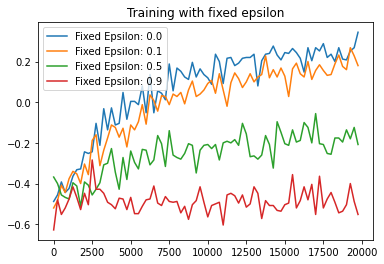

In [6]:
# Training with a fixed epsilon (Question 1)

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig,ax = plt.subplots()
plt.title("Training with fixed epsilon")

# List of epsilons to try 
epsilons= [0.0, 0.1, 0.5, 0.9]

for epsilon in epsilons:
    # Train and get the rewards for a fixed epsilon 
    player_rl_agent, rewards, _, _ = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=number_of_episodes)
    plot_rewards(number_of_episodes, rewards, ax, label=f"Fixed Epsilon: {epsilon}")


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [06:20<00:00, 52.60it/s]


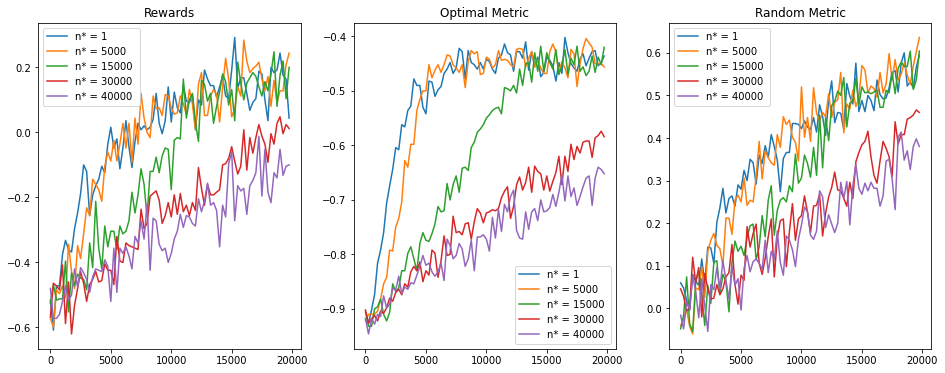

In [7]:
# Training with a monotonically decreasing epsilon (Question 2 and Question 3)

# RL Hyper-params
number_of_episodes = 20000
epsilon_min, epsilon_max = 0.1, 0.8

# Environment
environment = TictactoeEnv()

# Plots
fig, axes = plt.subplots(1, 3, figsize=(16, 6))
axes[0].set_title("Rewards")
axes[1].set_title("Optimal Metric")
axes[2].set_title("Random Metric")

list_of_number_of_exploratory_games = [1, 5000, 15000, 30000, 40000]
 
for number_of_exploratory_games in list_of_number_of_exploratory_games:
    # Train and get the rewards, M_opt, M_rand for a decreasing monotinically epsilon 
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=0.5, epsilon=epsilon, test_episode=250)
    plot_rewards(number_of_episodes,rewards, axes[0], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes,m_opt, axes[1], label = f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes,m_rand, axes[2], label = f"n* = {number_of_exploratory_games} ")


Now that we have explored the effect of the (fixed/varying) epsilon on the training performance, we will explore the effect of the optimality of the teacher on the training policy. Specifically, would the RL agent train better if it trained against an optimal policy or a random policy or somewhere in between?

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:49<00:00, 69.18it/s]


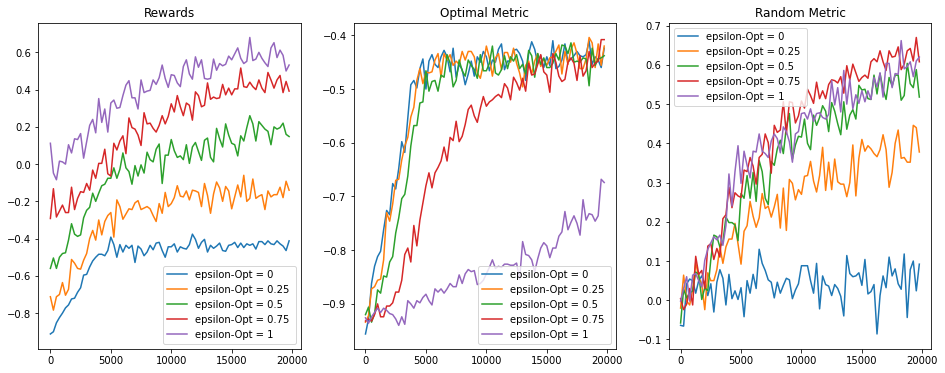

In [8]:
# Train with various Optimal level of the Agent for the optimal n* = 5000 (Question 4). 

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8
number_of_exploratory_games = 5000
epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))

# Environment
environment = TictactoeEnv()

# Plot
fig, axes = plt.subplots(1,3,figsize=(16,6))
axes[0].set_title("Rewards")
axes[1].set_title("Optimal Metric")
axes[2].set_title("Random Metric")

list_of_optimal_levels = [0,0.25,0.5,0.75,1]
for optimal_level in list_of_optimal_levels:
    # Train and get the rewards, M_opt, M_rand for a different optimality levels of the teacher  
    player_rl_agent, rewards, m_opt, m_rand = train_rl_agent_qlearning(environment, number_of_episodes=number_of_episodes, optimal_level=optimal_level,epsilon=epsilon, test_episode=250)
    plot_rewards(number_of_episodes,rewards, axes[0], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes,m_opt, axes[1], label = f"epsilon-Opt = {optimal_level} ")
    plot_metrics(number_of_episodes,m_rand, axes[2], label = f"epsilon-Opt = {optimal_level} ")


Now that we have deeply explored the performance the effect of the epsilon (exploration probability) and the optimality level of teacher. It would be interresting to see weather the RL Agent can learn by playing against it self since this capability is highly valued when we don't know what the optimal policy is (very common in real-life problems). 

With that, we implemented a new training procedure, where the RL agent plays againt it self by choosing actions from and updating the values of the same Q-table.

In [9]:
def train_rl_agent_self_learning(environment: TictactoeEnv, number_of_episodes: int, epsilon:float, test_episode:int, verbose: bool = False):
    # Initialize the Rewards and Test Metrics
    metrics_opt = np.zeros(int(number_of_episodes/test_episode))
    metrics_rand = np.zeros(int(number_of_episodes/test_episode))

    # Instantiate the Players
    player_rl_agent = RlAgent(epsilon=epsilon, player="X")

    for episode in tqdm(range(number_of_episodes)):
        
        # Reset the Environment
        environment.reset()
        
        #Observe the Environment
        grid, _, _ = environment.observe()
        
        # Give RL access to the board
        player_rl_agent.observe_state(grid)

        # Update nb of episode played
        player_rl_agent.update_nb_of_episode_played(episode) 

        # Number of RL movements 
        number_of_rl_movements = 0
        
        player_rl_agent.player = choose_self_learning_player(episode)
        for step in range(9):
            # if the RL player 1 first move, store player 1 current state and play player 1 current action 
            if (number_of_rl_movements == 0):
                rl_player_1_current_state = grid
                rl_player_1_current_action = player_rl_agent.act(grid)
                move = (int(rl_player_1_current_action/3),rl_player_1_current_action%3) 

                number_of_rl_movements=1

            # if the RL player 2 first move, store player 2 current state and play player 2 current action
            elif (number_of_rl_movements == 1):
                rl_player_2_current_state = grid
                rl_player_2_current_action = player_rl_agent.act(grid)
                move = (int(rl_player_2_current_action/3),rl_player_2_current_action%3) 

                number_of_rl_movements=2

            # if the RL player 1 second move, update player RL q-table 
            elif (number_of_rl_movements == 2):
                rl_player_1_next_state = grid
                rl_player_1_next_action = player_rl_agent.act(grid)
                move = (int(rl_player_1_next_action/3),rl_player_1_next_action%3)
                player_rl_agent.update_q_table(rl_player_1_current_state, rl_player_1_current_action, rl_player_1_next_state)

                rl_player_1_current_state = rl_player_1_next_state
                rl_player_1_current_action = rl_player_1_next_action
                number_of_rl_movements = 3

            # if the RL player 2 second move, update player RL q-table 
            elif (number_of_rl_movements == 3):
                rl_player_2_next_state = grid
                rl_player_2_next_action = player_rl_agent.act(grid)
                move = (int(rl_player_2_next_action/3),rl_player_2_next_action%3)
                player_rl_agent.update_q_table(rl_player_2_current_state, rl_player_2_current_action, rl_player_2_next_state)

                rl_player_2_current_state = rl_player_2_next_state
                rl_player_2_current_action = rl_player_2_next_action
                
                number_of_rl_movements = 0
                                

            grid, end, _ = environment.step(move, print_grid=False)
            player_rl_agent.observe_state(grid)
            player_rl_agent.observe_reward(environment.reward(player_rl_agent.player))
            
            if end:                
                if player_rl_agent.player == "X":
                    player_rl_agent.update_q_table(rl_player_1_current_state, rl_player_1_current_action, grid, terminal_state=True)
                else:
                    player_rl_agent.update_q_table(rl_player_2_current_state, rl_player_2_current_action, grid, terminal_state=True)
                environment.reset()
                break
        
        if (episode%test_episode == 0):
            m_opt, m_rand = compute_metrics(environment, player_rl_agent, 500)
            metrics_opt[int(episode/test_episode)] = m_opt
            metrics_rand[int(episode/test_episode)] = m_rand
    return player_rl_agent, metrics_opt, metrics_rand   




With that, we will proceed as before by evaluating the effect of fixed/varying epsilon on the self-learning training procedure by allowing the RL agent play against it self and updating the same Q-table.

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:44<00:00, 70.41it/s]


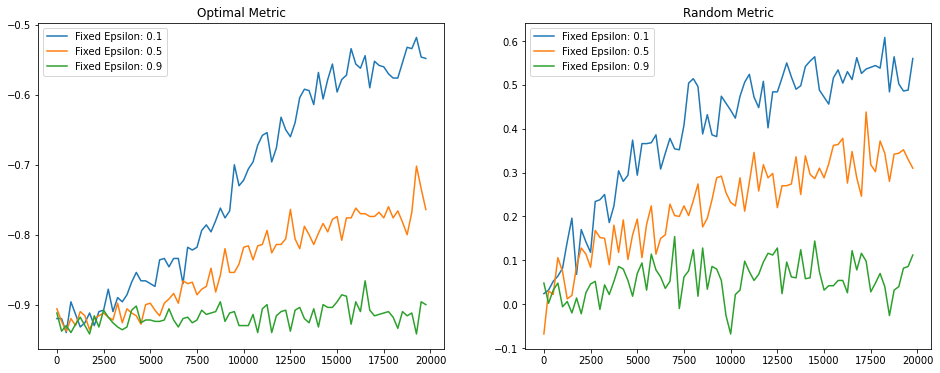

In [10]:
# Training by playing against it self with fixed epsilon (Question 7)

# RL Hyper-params
number_of_episodes = 20000

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")


list_of_epsilons = [0.1,0.5,0.9]
for epsilon in list_of_epsilons:
# Train and get the M_opt, and M_rand for a fixed epsilon
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)
    plot_metrics(number_of_episodes,m_opt, axes[0],label=f"Fixed Epsilon: {epsilon}")
    plot_metrics(number_of_episodes,m_rand, axes[1],label=f"Fixed Epsilon: {epsilon}")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20000/20000 [04:36<00:00, 72.33it/s]


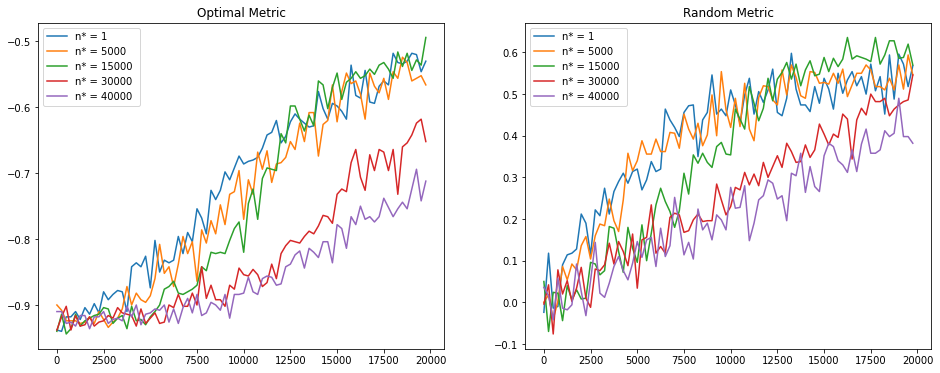

In [11]:
# Training by playing against it self with decreasing epsilon (Question 8)

# RL Hyper-params
number_of_episodes = 20000
epsilon_min,epsilon_max = 0.1, 0.8

# Environment
environment = TictactoeEnv()

# plots 
fig, axes = plt.subplots(1,2,figsize=(16,6))
axes[0].set_title("Optimal Metric")
axes[1].set_title("Random Metric")

list_of_number_of_exploratory_games = [1,5000,15000,30000,40000]

# Define the best player agent 
best_player_agent = None
best_m_opt, best_m_rand = -1, -1 
for number_of_exploratory_games in list_of_number_of_exploratory_games:
# Train and get the M_opt and M_rand for a number of exploratory games
    epsilon = lambda n: max(epsilon_min, epsilon_max*(1-(n/number_of_exploratory_games)))
    player_rl_agent, m_opt, m_rand = train_rl_agent_self_learning(environment, number_of_episodes=number_of_episodes,epsilon=epsilon, test_episode=250)
    
    if m_opt[-1]>best_m_opt and m_rand[-1]>best_m_rand:
        best_player_agent = player_rl_agent
        best_m_opt, best_m_rand = m_opt[-1], m_rand[-1]

    plot_metrics(number_of_episodes,m_opt, axes[0],label= f"n* = {number_of_exploratory_games} ")
    plot_metrics(number_of_episodes,m_rand, axes[1],label= f"n* = {number_of_exploratory_games} ")


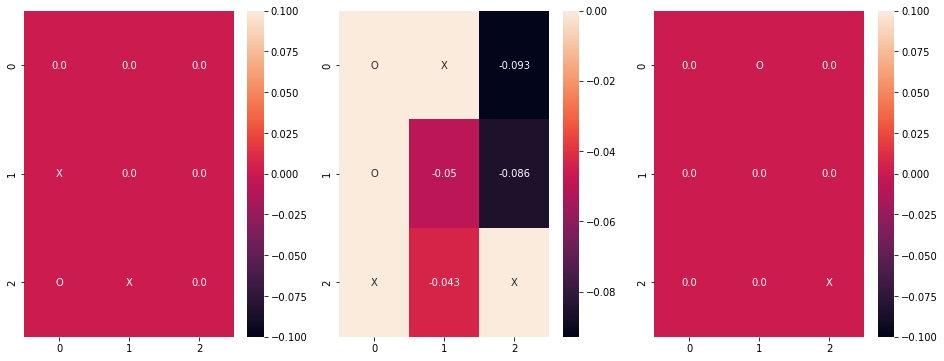

In [24]:
# get the best player agent
player_rl_agent = best_player_agent

# Visualize the heat map
number_of_visualized_states = 3
fig, ax = plt.subplots(ncols=3, figsize=(16,6))
for index in range(number_of_visualized_states):
    state = player_rl_agent.observed_states[randrange(len(player_rl_agent.observed_states))]
    state_key = player_rl_agent.get_state_key(state)
    q_values = player_rl_agent.q_table[state_key]
    q_values_reshaped = q_values.reshape((3,3))
    sns.heatmap(q_values_reshaped, annot = convert_value_to_play_character(state, q_values), ax=ax[index], fmt="")

